МФТИ ФИВТ: Курс Машинное Обучение (осень, 2016), Арсений Ашуха, ars.ashuha@gmail.com

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:
- Hastie, The Elements of Statistical Learning, https://goo.gl/k3wfEU, 10 Boosting and Additive Trees 337
- Соколов, Семинары по композиционным методам, https://goo.gl/sn8RyJ, http://goo.gl/ajNTQy

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall <номер_группы> <фамилия>``, к примеру -- ``ML2016_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 

<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Чем отличается AdaBoost от XGBoost? Перечислите принципиальные отличия. 

Идея XGBoost: ошибка уменьшается путем минимизации среднеквадратического отклонения базового алгоритма от вектора сдвигов на каждой итерации. Tree-based модель, для построения дерева использует критерий информативности, зависящий от оптимального вектора сдвига.
Идея AdaBoost: Минимизируем функционал ошибки, используя экспоненциальную функцию потерь. На каждой итерации алгоритма каждый новый классификатор и его вес жадно выбираются так, чтобы минимизировать эту функцию. Плоха для регрессии и для классификации на много классов.

**Вопрос 2**: Почему говорят, что AdaBoost неустойчив к выбросам?

AdaBoost подразумевает, что используется экспоненциальная функция потерь от минус отступа. Поэтому на больших выбросах, особенно на шумах, функция потерь экспоненциально возрастает. Следующие базовые алгоритмы начинают настраиваться на эти шумы. (лекции Воронцова)

**Вопрос 3**:  В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

l-мерное пространство предсказаний алгоритма. (семинары Соколова)

**Вопрос 4**: В чем заключается сокращение шага в градиентном бустинге? Как число итераций, необходимое для сходимости, зависит от размера шага η?

Чем меньше шаг, тем больше число итераций.Сокращение шага в градиентном бустинге нам нужно для вычисления нового ансамбля a_n

**Вопрос 5**: Что такое стохастический градиентный бустинг?

На каждом шаге алгоритма новое слагаемое считается опираясь не на всю обучающую выборку, а лишь на случайную подвыборку фиксированного размера. Как бы объединение градиентного бустинга и беггинга. Также можно брать не случайную подвыборку объектов, а еще и случайную подвыборку признаков объектов. Это называется техникой случайных подпространств. Подобная можификация дает выигрыш во вемени, а так же улучшает качество. 

-----------
PS: Если проверяющий не понял ответ на большинство вопросов, то будет пичалька. Пишите так, чтобы можно было разобраться. 

<h1 align="center">Boosting</h1> 

1) Задача 1 
![](./img/task11.png)
![](./img/task12.png)

Добавим каждому объекту выборки два дерева высоты 1 $A_i$ и $B_i$ с весами 0.5 и -0.5 соответственно следующим образом:

$\begin{equation*}
A_i = 
 \begin{cases}
   y_i &\text{$x_i \leqslant x$}\\
   -y_i &\text{otherwise}
 \end{cases}
\end{equation*}
$

$\begin{equation*}
B_i = 
 \begin{cases}
   -y_i &\text{$x_i \leqslant x$}\\
   y_i &\text{otherwise}
 \end{cases}
\end{equation*}
$

В точках $x==x_i$     $A_i = y_i$, $B_i = -y_i$. 

$0.5 \cdot y_i - 0.5 \cdot (-y_i) = y_i$.
В других точках $x \ne x_i$ аналогичными рассуждениями получится ноль. 
В итоге получили 2l классификаторов.

2) Найдите градиент логистичиской функции потерь для фиксированного объекта

$ \frac{dL}{d y'} = \frac{exp(-y*y')}{(1 + exp(-y*y'))}  $

где $y$ - известный ответ, $y'$ - ответ алгоритма

<h1 align="center">Binary Boosting Implementation</h1> 

Нужно реализовать двухклассовый бустинг с логистичиской функцией потерь. 

Длину шага -- или используйте $1.0*lr$ или подбирайте одномерной оптимизацией;

In [24]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
from scipy.optimize import minimize_scalar
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, lr=0.1):
        self.lr = lr   
        self.n_estimators = n_estimators
    
    def loss_grad(self, original_y, pred_y):
        M = original_y * pred_y
        return 1.0 / (1 + np.exp(-M)) * np.exp(-M) * (-original_y) 
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = [] 
        self.gamma_ = []
        a_n = np.zeros((X.shape[0],))
        
        for i in range(self.n_estimators):
            #print(i)
            grad = self.loss_grad(original_y, a_n)
            # Настройте базовый алгоритм на градиент, это классификация или регрессия?
            estimator = DecisionTreeRegressor()
            estimator.fit(X, -grad)
            b_n = estimator.predict(X)
            argmin = minimize_scalar(fun_for_min, args=(a_n - original_y, b_n))
            gamma = self.lr * argmin.x
            a_n += gamma * b_n
            
            self.gamma_.append(gamma)            
            self.estimators_.append(estimator)
            
        
        self.out_ = self.outliers(grad)

        return self

    def _predict(self, X):
        y_pred = [self.gamma_[i] * self.estimators_[i].predict(X) for i in range(self.n_estimators)]
        return y_pred
    
    def predict(self, X):
        y_pred = self._predict(X)
        return (np.sum(y_pred, axis=0) > 0) * 2 - 1
    
    def outliers(self, grad):
        return np.argsort(np.abs(grad))[-10:]
    
    

In [3]:
def fun_for_min(gamma, s, b_n):
    return np.sum((gamma * b_n + s) ** 2)

<h1 align="center">Simple test</h1> 

In [35]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

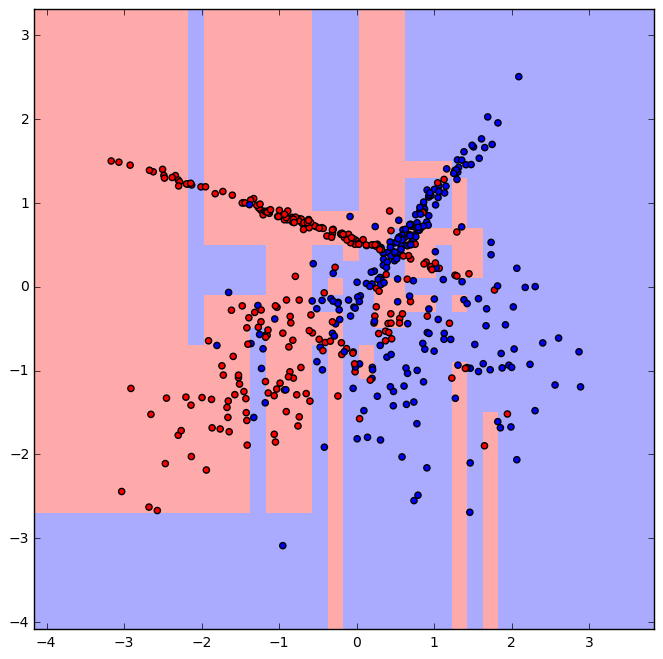

In [95]:
clf = BinaryBoostingClassifier().fit(X, y)
plot_surface(X, y, clf)

<h1 align="center">Outliers</h1> 

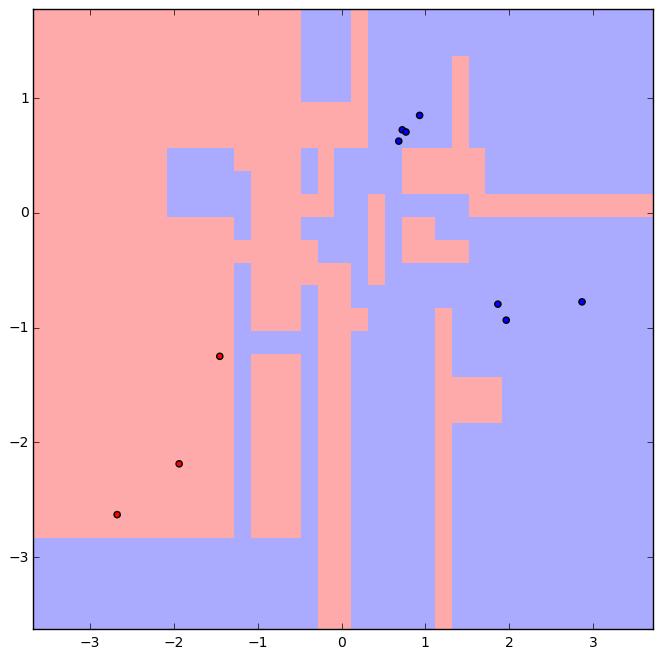

In [78]:
outliers = clf.out_
plot_surface(X[outliers], y[outliers], clf)

<h1 align="center">Adult test</h1> 

In [79]:
!sh ./get_data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3881k  100 3881k    0     0   257k      0  0:00:15  0:00:15 --:--:--  213k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0   619k      0  0:04:28  0:04:28 --:--:--  911k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [96]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [83]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [84]:
clf1 = GradientBoostingClassifier()
clf1.fit(X_train, y_train)
pred = clf1.predict(X_test)
accuracy_score(pred, y_test)

0.87350322382560641

In [98]:
clf2 = BinaryBoostingClassifier()
clf2.fit(X_train, y_train)
pred2 = clf2.predict(X_test)
accuracy_score(pred2, y_test)

0.82284310715382258

<h1 align="center">Text classification</h1> 

- Найдите двухклассовый текстовый датасет (в качестве примера sentiment analysis) или возьмите многоклассовый и классифцируйте один клас против остальных
- Попробуйте бустинг на решающих деревьях, в качестве фичей используйте tf-idf и svd/random_projection/hashing_trick, что работает лучше? Сравните качество и время работы.

In [5]:
data = pd.read_csv('./data/fine-food/train.csv', index_col=0, na_values='NaN')
print(data.shape)
print(data.head())

(10000, 2)
                                          Reviews_Summary  Prediction
ID                                                                   
230872                                  Babies love these           3
344823                                       Salmon Trout           0
211754                                     disappointment           1
259421  Doesn't taste like Cinnabon; tastes like Waffl...           2
253418  Delicious San Daniele prosciutto and good cust...           3


In [6]:
documents = data.Reviews_Summary.values
func = np.vectorize(lambda x: 1 if x == 0 or x == 1 else -1)
score = func(data.Prediction.values)

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=3000)
sparse_data = hv.transform(documents)

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(sparse_data)

In [9]:
from scipy import sparse
data_train = sparse.hstack([tfidf, np.ones((tfidf.shape[0], 1))])
#data_train = tfidf.toarray()

### it-idf на 100000-ом датасете

In [81]:
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(data_train, score)

In [31]:
%%time 
clf = GradientBoostingClassifier()
clf.fit(X_train.toarray(), y_train)
pred = clf.predict(X_test.toarray())
print accuracy_score(pred, y_test)

0.846
CPU times: user 3min 18s, sys: 0 ns, total: 3min 18s
Wall time: 3min 18s


In [33]:
%%time 
clf = BinaryBoostingClassifier()
clf.fit(X_train.toarray(), y_train)
pred = clf.predict(X_test.toarray())
print accuracy_score(pred, y_test)

0.8444
CPU times: user 6min 59s, sys: 24 ms, total: 6min 59s
Wall time: 6min 59s


### SVD на полном датасете

In [45]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, random_state=42)

clf = BinaryBoostingClassifier()
clf.fit(svd.fit_transform(X_train), y_train)
pred = clf.predict(svd.fit_transform(X_test))
print accuracy_score(pred, y_test)

0.742171000341
CPU times: user 4min 28s, sys: 76 ms, total: 4min 28s
Wall time: 4min 28s


In [46]:
%%time
clf = GradientBoostingClassifier()
clf.fit(svd.fit_transform(X_train), y_train)
pred = clf.predict(svd.fit_transform(X_test))
print accuracy_score(pred, y_test)

0.847507664358
CPU times: user 34.8 s, sys: 28 ms, total: 34.9 s
Wall time: 34.9 s


### Random_projection на датасете размера 10000

In [12]:
from sklearn.random_projection import SparseRandomProjection
rp = SparseRandomProjection(eps=0.5)

X_train, X_test, y_train, y_test = train_test_split(rp.fit_transform(data_train), score)

In [14]:
%%time
clf = GradientBoostingClassifier()
clf.fit(X_train.toarray(), y_train)
pred = clf.predict(X_test.toarray())
print accuracy_score(pred, y_test)

0.878
CPU times: user 14.7 s, sys: 8 ms, total: 14.7 s
Wall time: 14.7 s


In [13]:
%%time
clf = BinaryBoostingClassifier(n_estimators=50)
clf.fit(X_train.toarray(), y_train)
pred = clf.predict(X_test.toarray())
print accuracy_score(pred, y_test)

0.8452
CPU times: user 2min 23s, sys: 16 ms, total: 2min 23s
Wall time: 2min 23s


Кажется ясным, что if-idf без уменьшающих размерности фичей алгоритмов будет работать медленнее, но лучше. Поэтому нас не станут удивлять полученные результаты зависимости времени и скора от алгоритма. Также стоит отметить, что самописный BinaryBoostingClassifier работает почти так же хорошо при использовании только it-idf.

<h1 align="center">Random Forest vs Boosting</h1> 

Подберите 2+ датасета как минимум большой и маленький (не использованных в этом дз) и проведите сравнение random forest и градиентного бустинга, используйте реализации алгоритмов из библиотеки sklearn.

- Опишите результаты, почему тот или другой алгоритм на конкретном датасете работает лучше/хуже?
- Как вы настраивали гиперпараметры алгоритмов?
- Как вы проверяли качесво алгоритмов?

Датасеты взяты с kaggle.com. На маленьком датасете по звуку надо определить пол, на большом по информации о человеке - выдавать ли ему кредит. Предположительно и бустинг, и random forest будутработать одинаково. В качестве метрики будем использовать ROC_AUC. Параметр подберем grid_search по известным гайдам:

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

### Small dataset

In [30]:
data = pd.read_csv('./data/voice.csv')
df = pd.DataFrame(data)

In [31]:
score = df.label.apply(lambda x: 1 if x == 'male' else -1)
data = df.drop('label', 1)

In [41]:
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


In [32]:
X_train, X_test, y_train, y_test = train_test_split(data, score)

In [34]:
%%time
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print roc_auc_score(pred, y_test)

0.982077205882
CPU times: user 708 ms, sys: 4 ms, total: 712 ms
Wall time: 721 ms


In [46]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(data, score)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99106, std: 0.00656, params: {'n_estimators': 20},
  mean: 0.99243, std: 0.00609, params: {'n_estimators': 30},
  mean: 0.99316, std: 0.00528, params: {'n_estimators': 40},
  mean: 0.99357, std: 0.00502, params: {'n_estimators': 50},
  mean: 0.99397, std: 0.00466, params: {'n_estimators': 60},
  mean: 0.99376, std: 0.00418, params: {'n_estimators': 70},
  mean: 0.99344, std: 0.00425, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.9939689214724774)

In [47]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(data, score)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.99319, std: 0.00479, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.99327, std: 0.00455, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.99360, std: 0.00480, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.99194, std: 0.00594, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.99147, std: 0.00658, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.99319, std: 0.00483, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.99367, std: 0.00464, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.99304, std: 0.00503, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.99245, std: 0.00624, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.99199, std: 0.00605, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.99378, std: 0.00394, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.99397, std: 0.00486, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [25]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(100,151,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=13,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(data, score)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.99225, std: 0.00594, params: {'min_samples_split': 1000, 'min_samples_leaf': 100},
  mean: 0.99105, std: 0.00773, params: {'min_samples_split': 1200, 'min_samples_leaf': 100},
  mean: 0.99006, std: 0.00942, params: {'min_samples_split': 1400, 'min_samples_leaf': 100},
  mean: 0.99011, std: 0.00958, params: {'min_samples_split': 1600, 'min_samples_leaf': 100},
  mean: 0.98978, std: 0.00953, params: {'min_samples_split': 1800, 'min_samples_leaf': 100},
  mean: 0.98898, std: 0.01007, params: {'min_samples_split': 2000, 'min_samples_leaf': 100},
  mean: 0.99236, std: 0.00601, params: {'min_samples_split': 1000, 'min_samples_leaf': 110},
  mean: 0.99109, std: 0.00757, params: {'min_samples_split': 1200, 'min_samples_leaf': 110},
  mean: 0.98995, std: 0.00949, params: {'min_samples_split': 1400, 'min_samples_leaf': 110},
  mean: 0.99033, std: 0.00917, params: {'min_samples_split': 1600, 'min_samples_leaf': 110},
  mean: 0.98981, std: 0.00941, params: {'min_samples_split': 1800, 'mi

In [28]:
param_test4 = {'max_features':range(1,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=13, min_samples_split=1000, min_samples_leaf=120, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(data, score)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.97469, std: 0.03246, params: {'max_features': 1},
  mean: 0.99186, std: 0.00642, params: {'max_features': 3},
  mean: 0.99219, std: 0.00559, params: {'max_features': 5},
  mean: 0.99278, std: 0.00493, params: {'max_features': 7},
  mean: 0.99219, std: 0.00489, params: {'max_features': 9},
  mean: 0.99175, std: 0.00462, params: {'max_features': 11},
  mean: 0.99122, std: 0.00518, params: {'max_features': 13},
  mean: 0.99146, std: 0.00528, params: {'max_features': 15},
  mean: 0.99099, std: 0.00548, params: {'max_features': 17},
  mean: 0.99131, std: 0.00513, params: {'max_features': 19}],
 {'max_features': 7},
 0.99277946848961618)

In [29]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=13,min_samples_split=1000, min_samples_leaf=120, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(data, score)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.99244, std: 0.00632, params: {'subsample': 0.6},
  mean: 0.99283, std: 0.00547, params: {'subsample': 0.7},
  mean: 0.99305, std: 0.00519, params: {'subsample': 0.75},
  mean: 0.99278, std: 0.00493, params: {'subsample': 0.8},
  mean: 0.99258, std: 0.00468, params: {'subsample': 0.85},
  mean: 0.99296, std: 0.00439, params: {'subsample': 0.9}],
 {'subsample': 0.75},
 0.99305338261467835)

In [36]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=13,min_samples_split=1000, min_samples_leaf=70, subsample=0.75, random_state=10,max_features=7)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
#print roc_auc_score(pred, y_test)
print 0.988283057021

0.988283057021


In [37]:
%%time
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print accuracy_score(pred, y_test)

0.983585858586
CPU times: user 792 ms, sys: 84 ms, total: 876 ms
Wall time: 818 ms


In [45]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(data, score)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99188, std: 0.00473, params: {'n_estimators': 20},
  mean: 0.99291, std: 0.00429, params: {'n_estimators': 30},
  mean: 0.99286, std: 0.00424, params: {'n_estimators': 40},
  mean: 0.99235, std: 0.00614, params: {'n_estimators': 50},
  mean: 0.99314, std: 0.00378, params: {'n_estimators': 60},
  mean: 0.99448, std: 0.00352, params: {'n_estimators': 70},
  mean: 0.99389, std: 0.00399, params: {'n_estimators': 80}],
 {'n_estimators': 70},
 0.99447813506127447)

In [47]:
param_test2 = {'max_features':range(1,20,2)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=70),
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(data, score)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.99006, std: 0.00923, params: {'max_features': 1},
  mean: 0.99369, std: 0.00440, params: {'max_features': 3},
  mean: 0.99327, std: 0.00345, params: {'max_features': 5},
  mean: 0.99340, std: 0.00414, params: {'max_features': 7},
  mean: 0.99238, std: 0.00513, params: {'max_features': 9},
  mean: 0.99154, std: 0.00475, params: {'max_features': 11},
  mean: 0.99144, std: 0.00429, params: {'max_features': 13},
  mean: 0.99039, std: 0.00517, params: {'max_features': 15},
  mean: 0.98943, std: 0.00622, params: {'max_features': 17},
  mean: 0.98891, std: 0.00648, params: {'max_features': 19}],
 {'max_features': 3},
 0.99368747525011292)

In [51]:
param_test3 = {'min_samples_leaf':range(1,71,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=70, max_features=3),
                        param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(data, score)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.99260, std: 0.00555, params: {'min_samples_leaf': 1},
  mean: 0.99281, std: 0.00537, params: {'min_samples_leaf': 11},
  mean: 0.99155, std: 0.00656, params: {'min_samples_leaf': 21},
  mean: 0.99113, std: 0.00796, params: {'min_samples_leaf': 31},
  mean: 0.99026, std: 0.00869, params: {'min_samples_leaf': 41},
  mean: 0.98927, std: 0.01010, params: {'min_samples_leaf': 51},
  mean: 0.98900, std: 0.01119, params: {'min_samples_leaf': 61}],
 {'min_samples_leaf': 11},
 0.99280972465888395)

In [40]:
%%time
clf = RandomForestClassifier(n_estimators=70, max_features=3, min_samples_leaf=11)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print roc_auc_score(pred, y_test)

0.988283057021
CPU times: user 400 ms, sys: 4 ms, total: 404 ms
Wall time: 403 ms


### Big dataset

In [2]:
df = pd.DataFrame(pd.read_csv('./data/loans.csv'))
print df.shape
df.head()

(122607, 68)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [3]:
data = df[df.columns[2:18]].fillna(0)
data.emp_length = df.emp_length_num
score = df['bad_loans'].apply(lambda x: 1 if x == 0 else -1)

In [4]:
data = data.drop('emp_title', 1)

In [5]:
for c in data.columns:
    if data[c].dtype != np.int64 and data[c].dtype != np.float64:
        data[c] = pd.get_dummies(data[c])

In [6]:
data.shape, score.shape

((122607, 15), (122607,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, score)

In [27]:
%%time
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print roc_auc_score(pred, y_test)

0.994741060455
CPU times: user 9.6 s, sys: 16 ms, total: 9.61 s
Wall time: 9.61 s


In [145]:
param_test = {'n_estimators':range(20,81,10)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch.fit(data[:10000], score[:10000])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.99890, std: 0.00091, params: {'n_estimators': 20},
  mean: 0.99882, std: 0.00106, params: {'n_estimators': 30},
  mean: 0.99899, std: 0.00085, params: {'n_estimators': 40},
  mean: 0.99893, std: 0.00091, params: {'n_estimators': 50},
  mean: 0.99888, std: 0.00089, params: {'n_estimators': 60},
  mean: 0.99878, std: 0.00089, params: {'n_estimators': 70},
  mean: 0.99877, std: 0.00088, params: {'n_estimators': 80}],
 {'n_estimators': 40},
 0.99899438625550729)

In [146]:
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=40, learning_rate=0.1,min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch.fit(data[:10000], score[:10000])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.99896, std: 0.00094, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.99913, std: 0.00080, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.99900, std: 0.00086, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.99910, std: 0.00078, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.99906, std: 0.00068, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.99899, std: 0.00091, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.99878, std: 0.00095, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.99911, std: 0.00087, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.99928, std: 0.00067, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.99916, std: 0.00061, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.99915, std: 0.00066, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.99915, std: 0.00067, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [10]:
param_test = {'min_samples_leaf':range(50,151,10)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=40, min_samples_split=400, max_depth=11,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch.fit(data[:10000], score[:10000])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.99930, std: 0.00062, params: {'min_samples_leaf': 50},
  mean: 0.99907, std: 0.00083, params: {'min_samples_leaf': 60},
  mean: 0.99904, std: 0.00082, params: {'min_samples_leaf': 70},
  mean: 0.99932, std: 0.00053, params: {'min_samples_leaf': 80},
  mean: 0.99907, std: 0.00074, params: {'min_samples_leaf': 90},
  mean: 0.99861, std: 0.00110, params: {'min_samples_leaf': 100},
  mean: 0.99892, std: 0.00094, params: {'min_samples_leaf': 110},
  mean: 0.99897, std: 0.00083, params: {'min_samples_leaf': 120},
  mean: 0.99896, std: 0.00084, params: {'min_samples_leaf': 130},
  mean: 0.99901, std: 0.00074, params: {'min_samples_leaf': 140},
  mean: 0.99895, std: 0.00112, params: {'min_samples_leaf': 150}],
 {'min_samples_leaf': 80},
 0.99932100898502296)

In [13]:
param_test = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=40,learning_rate=0.1, min_samples_split=400,min_samples_leaf=80,max_depth=11,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch.fit(data[:10000], score[:10000])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.99898, std: 0.00091, params: {'subsample': 0.6},
  mean: 0.99921, std: 0.00067, params: {'subsample': 0.7},
  mean: 0.99935, std: 0.00054, params: {'subsample': 0.75},
  mean: 0.99932, std: 0.00053, params: {'subsample': 0.8},
  mean: 0.99920, std: 0.00062, params: {'subsample': 0.85},
  mean: 0.99908, std: 0.00087, params: {'subsample': 0.9}],
 {'subsample': 0.75},
 0.99935230901761507)

In [28]:
%%time
clf = GradientBoostingClassifier(n_estimators=40,learning_rate=0.1, min_samples_split=400,min_samples_leaf=80,max_depth=11,max_features='sqrt',subsample=0.75,random_state=10)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print roc_auc_score(pred, y_test)

0.995265565944
CPU times: user 9.03 s, sys: 4 ms, total: 9.04 s
Wall time: 9.04 s


In [25]:
%%time
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print roc_auc_score(pred, y_test)

0.994741060455
CPU times: user 11 s, sys: 16 ms, total: 11 s
Wall time: 11 s


In [16]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(data[:10000], score[:10000])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99854, std: 0.00073, params: {'n_estimators': 20},
  mean: 0.99817, std: 0.00116, params: {'n_estimators': 30},
  mean: 0.99876, std: 0.00096, params: {'n_estimators': 40},
  mean: 0.99842, std: 0.00146, params: {'n_estimators': 50},
  mean: 0.99883, std: 0.00104, params: {'n_estimators': 60},
  mean: 0.99898, std: 0.00089, params: {'n_estimators': 70},
  mean: 0.99887, std: 0.00101, params: {'n_estimators': 80}],
 {'n_estimators': 70},
 0.99898304326444243)

In [20]:
param_test2 = {'min_samples_leaf':range(1,71,5)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=70, max_features=10),
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(data[:10000], score[:10000])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.99846, std: 0.00097, params: {'min_samples_leaf': 1},
  mean: 0.99839, std: 0.00102, params: {'min_samples_leaf': 6},
  mean: 0.99826, std: 0.00111, params: {'min_samples_leaf': 11},
  mean: 0.99859, std: 0.00125, params: {'min_samples_leaf': 16},
  mean: 0.99818, std: 0.00115, params: {'min_samples_leaf': 21},
  mean: 0.99836, std: 0.00141, params: {'min_samples_leaf': 26},
  mean: 0.99811, std: 0.00118, params: {'min_samples_leaf': 31},
  mean: 0.99831, std: 0.00085, params: {'min_samples_leaf': 36},
  mean: 0.99807, std: 0.00119, params: {'min_samples_leaf': 41},
  mean: 0.99807, std: 0.00102, params: {'min_samples_leaf': 46},
  mean: 0.99891, std: 0.00094, params: {'min_samples_leaf': 51},
  mean: 0.99875, std: 0.00116, params: {'min_samples_leaf': 56},
  mean: 0.99847, std: 0.00117, params: {'min_samples_leaf': 61},
  mean: 0.99861, std: 0.00082, params: {'min_samples_leaf': 66}],
 {'min_samples_leaf': 51},
 0.99890541913489694)

In [21]:
param_test3 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=70, max_features=10, min_samples_leaf=51),
                        param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(data[:10000], score[:10000])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.99846, std: 0.00124, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.99857, std: 0.00107, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.99921, std: 0.00069, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.99917, std: 0.00072, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.99911, std: 0.00086, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.99795, std: 0.00184, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.99911, std: 0.00086, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.99887, std: 0.00085, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.99913, std: 0.00082, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.99910, std: 0.00095, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.99838, std: 0.00119, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.99900, std: 0.00077, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [26]:
%%time
clf = RandomForestClassifier(n_estimators=70, max_features=10, min_samples_leaf=51, max_depth=13, min_samples_split=600)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print roc_auc_score(pred, y_test)

0.995245862508
CPU times: user 14.6 s, sys: 12 ms, total: 14.6 s
Wall time: 14.6 s


### Выводы

Все работает одинаково хорошо( Подбором параметров добились небольшого улучшения ROC_AUC. 

<h1 align="center">Bonus part</h1> 

Это удвоит баллы за дз.

- Реализуйте мультиклассовый бустинг -- проверьте на CIFAR10 + SVD
- Попробуйте различные функции потерь, придумайте несколько своих, удалось ли обойти логистичискую и экспоненциальную?